## Carichiamo le immagini LDR

Percentuale di informazione mantenuta:
Immagine 1 : 0.980190625
Immagine 2 : 0.9988503472222222
Immagine 3 : 0.9999920138888889


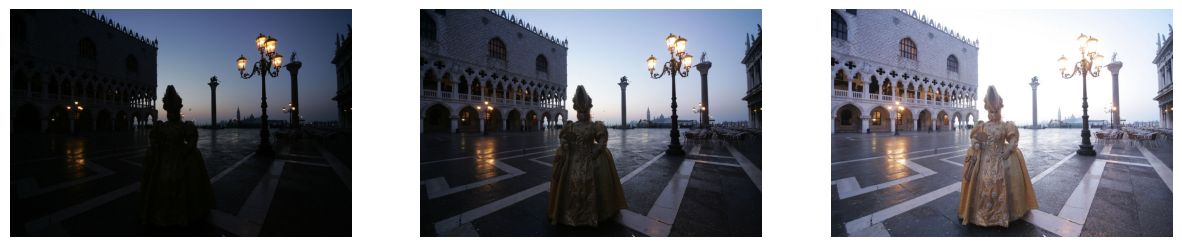

In [25]:
import numpy as np
from PIL import Image
from skimage import img_as_float
import matplotlib.pyplot as plt

DIR_PATH = 'images/2/'

# Carica le immagini e convertile in array NumPy
img1 = img_as_float(np.array(Image.open(f'{DIR_PATH}/A.jpg').convert('RGB')))
img2 = img_as_float(np.array(Image.open(f'{DIR_PATH}/B.jpg').convert('RGB')))
img3 = img_as_float(np.array(Image.open(f'{DIR_PATH}/C.jpg').convert('RGB')))

# Mette le immagini in una lista
images = [img1, img2, img3]

# Visualizza le immagini da fondere
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(images[i])
    ax[i].axis('off')

# Calcola la percentuale di informazione mantenuta
print("Percentuale di informazione mantenuta:")
for i, img in enumerate(images):
    print(f"Immagine {i+1} : {np.count_nonzero(img)/(img.size)}")

## Calcoliamo i pesi delle immagini LDR

Immagine 1: 0.8830083333333333
Immagine 2: 0.9844010416666666
Immagine 3: 0.858365625


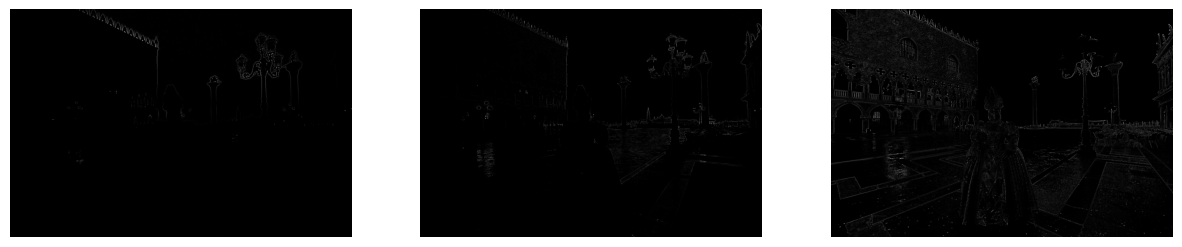

In [26]:
from skimage.color import rgb2gray
from skimage.filters import sobel, laplace
from scipy.ndimage import gaussian_laplace, convolve

def gauss_curve(i,sigma=0.2):
    return np.exp(-(i-0.5)**2/(2*sigma**2))

def calculate_weights(images):
    weights = []
    for img in images:
        # Conversione dell'immagine in scala di grigi
        gray = rgb2gray(img)

        # Calcolo l'indicatore di contrasto applicando il filtro di Laplace sull'immagine in scala di grigi
        # OLD
        # contrast = abs(laplace(gray))
        contrast =abs(gaussian_laplace(gray,sigma=1))

        # Saturazione dell'immagine calcolata come deviazione standard dei valori dei pixel
        saturation = np.std(img, axis=2)
        
        # Esposizione dell'immagine calcolata come prodotto di gaussiane
        well_exposedness = np.prod(gauss_curve(img), axis=2)

        # Definizione dei pesi
        omega_C=1
        omega_S=1
        omega_E=1
        
        # Calcolo della weight map
        weight_mapped =  (contrast ** omega_C) * (saturation ** omega_S) * (well_exposedness ** omega_E)

        weights.append( weight_mapped)
    return weights

weights = calculate_weights(images)

# Visualizza i pesi calcolati
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(weights[i], cmap='gray')
    ax[i].axis('off')

# Calcola la percentuale di informazione mantenuta
for i in range(3):
    print(f"Immagine {i+1}: {np.count_nonzero(weights[i])/(weights[i].size)}")

### Esempio dei pesi calcolati su un'immagine LDR

0.910990625
0.9844010416666666
1.0


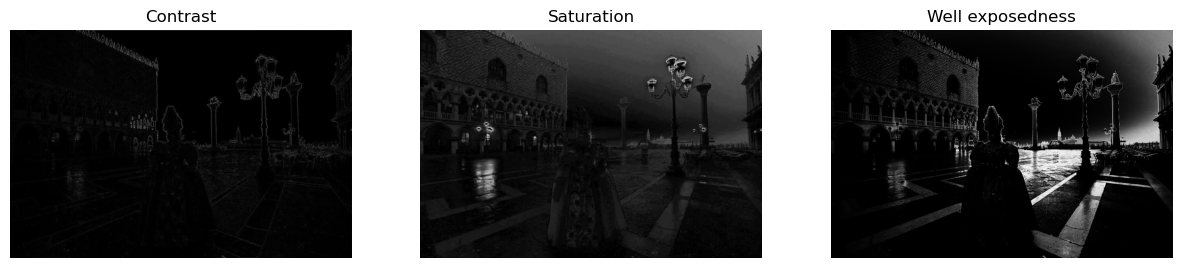

In [27]:
# Seleziona un'immagine campione
sample_img = img2

# Conversione dell'immagine in scala di grigi
gray = rgb2gray(sample_img)

# Calcolo l'indicatore di contrasto applicando il filtro di Laplace sull'immagine in scala di grigi
# OLD
contrast = abs(convolve(gray, np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]]), mode='constant', cval=0.0))
# contrast = abs(sobel(gray))
# contrast = abs(laplace(gray))
# contrast = abs(gaussian_laplace(gray,sigma=1))

# Saturazione dell'immagine calcolata come deviazione standard dei valori dei pixel
saturation = np.std(sample_img, axis=2)

# Esposizione dell'immagine calcolata come prodotto di) gaussiane
well_exposedness = np.prod(gauss_curve(sample_img), axis=2)

# Visualizza i tre indicatori di qualità dell'immagine
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(contrast, cmap='gray')
ax[0].set_title('Contrast')
ax[0].axis('off')
ax[1].imshow(saturation, cmap='gray')
ax[1].set_title('Saturation')
ax[1].axis('off')
ax[2].imshow(well_exposedness, cmap='gray')
ax[2].set_title('Well exposedness')
ax[2].axis('off')

# Calcola la percentuale di informazione mantenuta
print(np.count_nonzero(contrast)/(contrast.size))
print(np.count_nonzero(saturation)/(saturation.size))
print(np.count_nonzero(well_exposedness)/(well_exposedness.size))


## Normalizzazione dei pesi delle immagini LDR

Immagine 1: 0.8830083333333333
Immagine 2: 0.9844010416666666
Immagine 3: 0.858365625


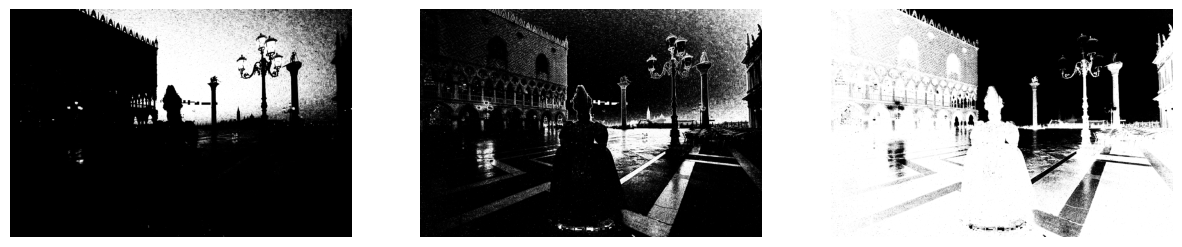

In [28]:
#  OLD CODE
# def normalize_weights(weights):
#     normalized_weights = []
#     total_weight = np.sum(weights, axis=0)
    
#     # Controllo se la somma dei pesi è zero
#     if np.any(total_weight == 0):
#         raise ValueError("Sum of weights contains zero, cannot normalize.")

#     # Normalizzazione dei pesi
#     for img_weight in weights:
#         # Calcolo del peso normalizzato
#         normalized_weight = img_weight / total_weight
#         normalized_weights.append(normalized_weight)

#     return normalized_weights

# Inizializzo la somma dei pesi
sum_weights = np.zeros(weights[0].shape)

# Faccio la somma dei pesi
for w in weights:
    sum_weights += w

# Nel caso in cui la somma dei pesi sia zero, la imposto a 1
sum_weights[sum_weights == 0] = 1

# Normalizzo i pesi
normalized_weights = weights / sum_weights

# Visualizza i pesi normalizzati
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(normalized_weights[i], cmap='gray')
    ax[i].axis('off')

# Calcola la percentuale di informazione mantenuta
for i in range(3):
    print(f"Immagine {i+1}: {np.count_nonzero(normalized_weights[i])/(normalized_weights[i].size)}")

### Visualizzimo i pesi delle immagini LDR del paper

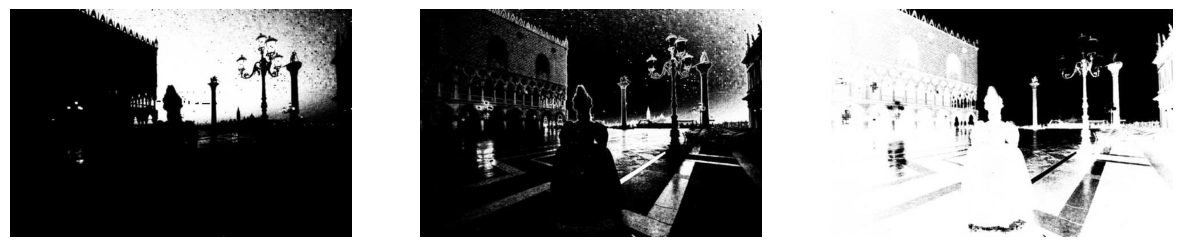

In [29]:
# Caricare le immagini pesate del paper
mapped_images_paper = [img_as_float(np.array(Image.open(f'{DIR_PATH}/image{i}_mapped.jpg').convert('RGB'))) for i in range(1, 4)]

# Visualizza le immagini pesate del paper
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax[i].imshow(mapped_images_paper[i])
    ax[i].axis('off')

### Risultato parziale

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Risultato del paper')

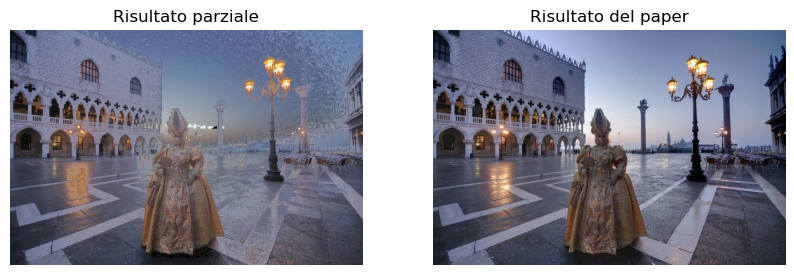

In [30]:
# Calcolo risultato parziale dell'immagine

# Inizializza l'immagine risultante
result = np.zeros_like(images[0], dtype=np.float64)

# Calcola l'immagine risultante
for i,w in enumerate(normalized_weights):
    result+= w[:, :, np.newaxis] * images[i]


paper_image = img_as_float(np.array(Image.open(f'{DIR_PATH}/result.jpg').convert('RGB')))

# Visualizza l'immagine risultante
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(result)
ax[0].axis('off')
ax[0].set_title('Risultato parziale')
ax[1].imshow(paper_image)
ax[1].axis('off')
ax[1].set_title('Risultato del paper')

## Bozza per le piramidi

#### Piramide gaussiana

(800, 1200, 3)
(400, 600, 3)
(200, 300, 3)
(100, 150, 3)
(50, 75, 3)
(25, 38, 3)
(13, 19, 3)
(7, 10, 3)
(4, 5, 3)
(2, 3, 3)
(1, 2, 3)
(1, 1, 3)


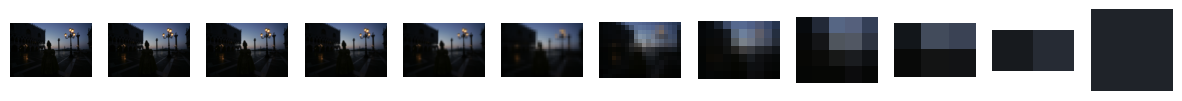

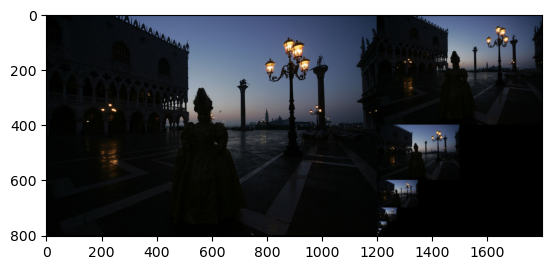

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.transform import pyramid_gaussian


image = img1
rows, cols, dim = image.shape
pyramid = list(pyramid_gaussian(image, downscale=2, channel_axis=-1))

# Visualizza le immagini della piramide
fig, ax = plt.subplots(1, len(pyramid), figsize=(15, 5))

for i, layer in enumerate(pyramid):
    print(layer.shape)
    ax[i].imshow(layer)
    ax[i].axis('off')
plt.show()

# Determina la dimensione dell'immagine composita
composite_rows = max(rows, sum(p.shape[0] for p in pyramid[1:]))
composite_cols = cols + pyramid[1].shape[1]
composite_image = np.zeros((composite_rows, composite_cols, 3), dtype=np.double)

# Inserisci l'immagine originale nell'immagine composita
composite_image[:rows, :cols, :] = pyramid[0]

# inpilate tutte le immagini ridimensionate in una colonna a destra dell'originale
i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row : i_row + n_rows, cols : cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()


#### Piramide di Laplace

(800, 1200)
(400, 600)
(200, 300)
(100, 150)
(50, 75)
(25, 38)
(13, 19)
(7, 10)
(4, 5)
(2, 3)
(1, 2)
(1, 1)


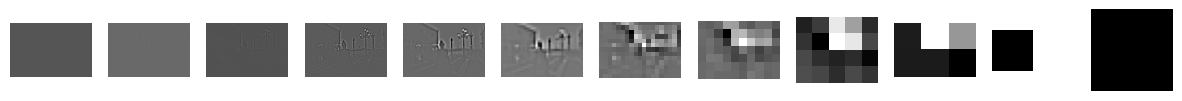

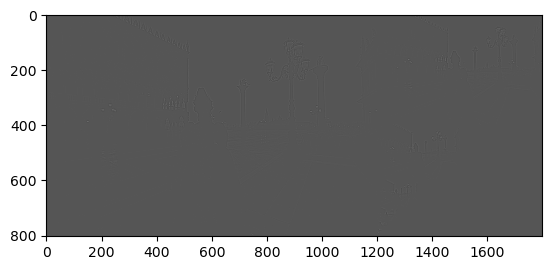

In [32]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import pyramid_laplacian


image = rgb2gray(img1)
rows, cols= image.shape
pyramid = list(pyramid_laplacian(image, downscale=2, mode='reflect'))

# Visualizza le immagini della piramide
fig, ax = plt.subplots(1, len(pyramid), figsize=(15, 5))

for i, layer in enumerate(pyramid):
    print(layer.shape)
    ax[i].imshow(layer, cmap='gray')
    ax[i].axis('off')
plt.show()

# Determina la dimensione dell'immagine composita
composite_rows = max(rows, sum(p.shape[0] for p in pyramid[1:]))
composite_cols = cols + pyramid[1].shape[1]
composite_image = np.zeros((composite_rows, composite_cols), dtype=np.double)

# Inserisci l'immagine originale nell'immagine composita
composite_image[:rows, :cols] = pyramid[0]

# inpilate tutte le immagini ridimensionate in una colonna a destra dell'originale
i_row = 0
for p in pyramid[1:]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row : i_row + n_rows, cols : cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image, cmap='gray')
plt.show()


## Fusione con le piramidi

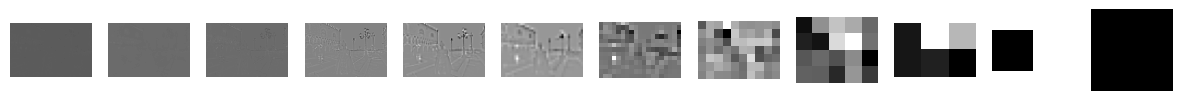

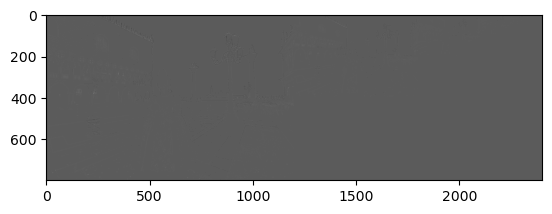

In [33]:
images_laplacian_pyramids = [list(pyramid_laplacian(rgb2gray(img))) for img in images]
weights_gaussian_pyramids = [list(pyramid_gaussian(w, downscale=2)) for w in weights]

result_pyramid = []
for l in range(len(images_laplacian_pyramids[0])):
    result_layer = np.zeros_like(images_laplacian_pyramids[0][l])
    for i in range(len(images_laplacian_pyramids)):
        result_layer += images_laplacian_pyramids[i][l] * weights_gaussian_pyramids[i][l]
    result_pyramid.append(result_layer)

# Visualizza la piramide risultante
fig, ax = plt.subplots(1, len(result_pyramid), figsize=(15, 5))
for i, layer in enumerate(result_pyramid):
    ax[i].imshow(layer, cmap='gray')
    ax[i].axis('off')
plt.show()

# Determina la dimensione dell'immagine composita
composite_rows = max(layer.shape[0] for layer in result_pyramid)
composite_cols = sum(layer.shape[1] for layer in result_pyramid)
composite_image = np.zeros((composite_rows, composite_cols), dtype=np.double)

# Inserisci l'immagine originale nell'immagine composita
composite_image[:result_pyramid[0].shape[0], :result_pyramid[0].shape[1]] = result_pyramid[0]

# inpilate tutte le immagini ridimensionate in una colonna a destra dell'originale
i_col = result_pyramid[0].shape[1]
for layer in result_pyramid[1:]:
    n_rows, n_cols = layer.shape[:2]
    composite_image[:n_rows, i_col : i_col + n_cols] = layer
    i_col += n_cols

fig, ax = plt.subplots()
ax.imshow(composite_image, cmap='gray')
plt.show()

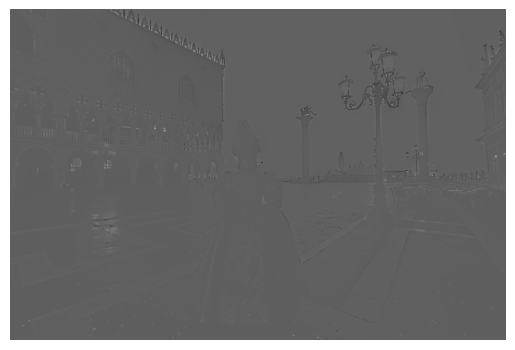

In [34]:
import numpy as np
from skimage.transform import pyramid_expand

def collapse_pyramid(laplacian_pyramid):
    image = laplacian_pyramid[-1]
    for level in reversed(laplacian_pyramid[:-1]):
        image = pyramid_expand(image)
        image = image[:level.shape[0], :level.shape[1]] 
        image += level
    return image

result_weight = collapse_pyramid(result_pyramid)
# Converto in immagine
result_weight = np.reshape(result_weight, weights[0].shape)

plt.imshow(result_weight, cmap='gray')
plt.axis('off')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 1199.5, 799.5, -0.5)

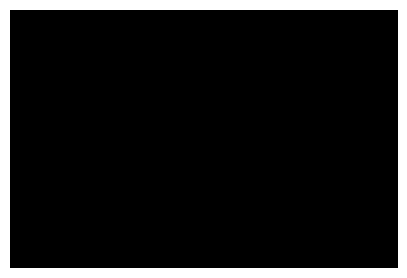

In [35]:
# Inizializza l'immagine risultante
result = np.zeros_like(images[0], dtype=np.float64)

# Calcola l'immagine risultante
for img in images:
    result += result_weight[:, :, np.newaxis] * img

# Visualizza il risultato parziale
plt.figure(figsize=(5, 5))
plt.imshow(result)
plt.axis('off')

## Collassiamo la piramide
Algoritmo preso dal paper article_lr

In [36]:
import numpy as np
from skimage.transform import pyramid_expand

def upsample(image, scale=2):
    return pyramid_expand(image, upscale=scale)

def laplacian_pyramid_reconstruction(laplacian_pyramid):
    lmax = len(laplacian_pyramid) - 1
    u = laplacian_pyramid[lmax]  # residual

    for l in range(lmax - 1, -1, -1):
        oddh = laplacian_pyramid[l].shape[0] - 2 * u.shape[0]
        oddw = laplacian_pyramid[l].shape[1] - 2 * u.shape[1]
        u = laplacian_pyramid[l] + upsample(u)
        if oddh == 1:
            u = np.vstack((u, np.zeros((1, u.shape[1], u.shape[2]))))
        if oddw == 1:
            u = np.hstack((u, np.zeros((u.shape[0], 1, u.shape[2]))))

    return u

reconstructed_image = laplacian_pyramid_reconstruction(result_pyramid)

plt.imshow(reconstructed_image)
plt.axis('off')
plt.show()



ValueError: operands could not be broadcast together with shapes (2,3) (4,4) 